**sklearn04_1_客户汽车满意度预测**
> **●案例描述**
>> + 本案例为《机器学习实践》课程第四章分类模型配套代码。
>> + 数据集Car Evaluation来自UCI，建模前对数据进行了适当的预处理。
>> + 从汽车的价格、质量、及舒适度这三个方面的相关数据（详见数据说明）出发，对汽车的客户满意度（简称为汽车满意度）进行分类预测。

> **●数据集**
>>数据一共包含6个特征，1个类别变量（即汽车满意度），共1728个样本点。<br>
▶本地地址：`file_path = "./dataSets/data_chap4/CarEvaluation.csv"`<br>
▶数据集链接：http://archive.ics.uci.edu/ml/datasets/Car+Evaluation

|特征|说明|
|-----:|-----:|
|buying|购买价格（1：low；2：med；3：high；4：vhigh）|
|maint|保养价格（1：low；2：med；3：high；4：vhigh）|
|doors|门的个数（1：2；2：3；3：4；4：5more）|
|persons|载客数（1：2；2：4；3：more）|
|lug_boot|车身的大小（1：small；2：med；3：big）|
|safety|安全等级（1：low；2：med；3：high）|
|car_acceptability|汽车满意度（1：unacc；0：acc）|

**目录** <br>
[1. 准备](#1)<br>
[2. 逻辑回归](#2)<br>
[3. K近邻](#3)<br>
[4. 决策树](#4)<br>
[5. 朴素贝叶斯](#5)<br>
[6. SVM](#6)<br>

导入所需库：
```python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
```

In [42]:
# 导入基本库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [43]:
plt.rcParams['font.sans-serif']=['SimHei']   #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False     #用来正常显示负号

<div id="1"></div>

# 1. 准备

## 读取数据

In [44]:
## 读取数据
file_path = "./dataSets/data_chap4/CarEvaluation.csv"
raw_data = pd.read_csv(file_path)

# 查看前5个样本
raw_data.head()

,buying,maint,doors,persons,lug_boot,safety,car_acceptability
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [45]:
# 数据形状
raw_data.shape

(1728, 7)

In [46]:
# 查看统计info
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
buying               1728 non-null object
maint                1728 non-null object
doors                1728 non-null object
persons              1728 non-null object
lug_boot             1728 non-null object
safety               1728 non-null object
car_acceptability    1728 non-null object
dtypes: object(7)
memory usage: 94.6+ KB


↑♎：没有缺失值，所有的类型都为`object(非数值)`,需要对object(非数值)特征进行数值编码，在此之前，先考察一下各个特征的`unique()`值

In [47]:
# 构建也给字典k:v，用于保存结果，k=特征，v=特征的唯一值
unique_data = {}
# 取出所有特征名
col_s = raw_data.columns
# 遍历特征，求unique()
#unique()它的功能是元素去重
for col in col_s:
    unique_data[col]=raw_data[col].unique()


unique_data

{'buying': array(['vhigh', 'high', 'med', 'low'], dtype=object),
 'maint': array(['vhigh', 'high', 'med', 'low'], dtype=object),
 'doors': array(['2', '3', '4', '5more'], dtype=object),
 'persons': array(['2', '4', 'more'], dtype=object),
 'lug_boot': array(['small', 'med', 'big'], dtype=object),
 'safety': array(['low', 'med', 'high'], dtype=object),
 'car_acceptability': array(['unacc', 'acc', 'vgood', 'good'], dtype=object)}

↑♎：`'car_acceptability'`中有4类，但根据项目要求，只预测`'unacc'`和`'acc'`两类，那么该特征中`'vgood'`和`'good'`的都应该属于`acc`。故需要进行`replace()`

In [48]:
# 采用映射{"vgood":"acc","good":"acc"}更新特征'car_acceptability'，注意原位操作，即inplace=True
raw_data['car_acceptability'].replace({"vgood":"acc","good":"acc"},inplace=True)

In [49]:
# 再次查看'car_acceptability'的unique()
raw_data['car_acceptability'].unique()

array(['unacc', 'acc'], dtype=object)

In [50]:
# 统计每类别中的样品数量
raw_data['car_acceptability'].value_counts()

unacc    1210
acc       518
Name: car_acceptability, dtype: int64

## 数值编码

> |特征|编码说明|
|:-----|:-----|
|buying|	购买价格（1：low；2：med；3：high；4：vhigh）|
|maint	|保养价格（1：low；2：med；3：high；4：vhigh）|
|doors	|门的个数（1：2；2：3；3：4；4：5more）|
|persons	|载客数（1：2；2：4；3：more）|
|lug_boot	|车身的大小（1：small；2：med；3：big）|
|safety	|安全等级（1：low；2：med；3：high）|
|car_acceptability	|汽车满意度（1：unacc（不满意）；0：acc（满意））|

根据要求对`'buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety','car_acceptability'`做`map()`

**思考一个问题：**这里使用`pd.get_dummies()`为各特征做数值编码，可以吗？ 与`map()`相比，区别在什么地方？针对这个实际问题，哪个更合适呢？ 另外使用`LabelEncoder`进行数值编码可以吗？

In [51]:
# 构建一个名称为data的空DF，用于存放处理后的数据
data = pd.DataFrame()

In [52]:
# 根据上表依次做map()
data['buying'] = raw_data['buying'].map({'vhigh':4, 'high':3, 'med':2, 'low':1})
data['maint'] = raw_data['maint'].map({'vhigh':4, 'high':3, 'med':2, 'low':1})
data['doors'] = raw_data['doors'].map({'2':1, '3':2, '4':3, '5more':4})
data['persons'] = raw_data['persons'].map({'2':1, '4':2, 'more':3})
data['lug_boot'] = raw_data['lug_boot'].map({'small':1, 'med':2, 'big':3})
data['safety'] = raw_data['safety'].map({'high':3, 'med':2, 'low':1})
data['car_acceptability'] = raw_data['car_acceptability'].map({'unacc':1, 'acc':0})

In [53]:
# 随机查看data的5个样本
data.sample(5)

,buying,maint,doors,persons,lug_boot,safety,car_acceptability
628,3,3,4,1,3,2,1
1421,1,3,1,2,3,3,0
1295,2,1,4,3,3,3,0
1142,2,2,3,1,3,3,1
405,4,1,4,1,1,1,1


In [54]:
# 查看第836个样本
data.iloc[835]

buying               3
maint                1
doors                3
persons              3
lug_boot             3
safety               2
car_acceptability    0
Name: 835, dtype: int64

In [55]:
# 查看info()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
buying               1728 non-null int64
maint                1728 non-null int64
doors                1728 non-null int64
persons              1728 non-null int64
lug_boot             1728 non-null int64
safety               1728 non-null int64
car_acceptability    1728 non-null int64
dtypes: int64(7)
memory usage: 94.6 KB


In [15]:
# 查看raw_data的前几行
raw_data.head()

,buying,maint,doors,persons,lug_boot,safety,car_acceptability
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [16]:
# 查看data的前几行
data.head()

,buying,maint,doors,persons,lug_boot,safety,car_acceptability
0,4,4,1,1,1,1,1
1,4,4,1,1,1,2,1
2,4,4,1,1,1,3,1
3,4,4,1,1,2,1,1
4,4,4,1,1,2,2,1


## 数据保存
> 编码后保存为`"./dataSets/data_chap4/car_evaluate.csv"`


In [17]:
# 保存地址
new_file= "./dataSets/data_chap4/car_evaluate.csv"

In [18]:
data.to_csv?

In [19]:
# 保存数据到文件,不要索引，即index=False
data.to_csv(new_file,index=False)

另外，还可以使用`LabelEncoder`进行数值编码，但是可能不一定都能满足我们的编码要求。

In [20]:
# from sklearn.preprocessing import LabelEncoder
# data1 = pd.DataFrame()
# ## 选出需要进行数值编码的特征
# col_s = raw_data.columns
# ## 数值编码
# for col in col_s:
#     data1[col] = LabelEncoder().fit_transform(raw_data[col])
    
# data1.iloc[835]

## 探索样本均衡性
> 对预测目标类别的数量分布进行分析，探索样本均衡性

In [21]:
# 统计目标类别中每个类别的样本个数
data['car_acceptability'].value_counts()

1    1210
0     518
Name: car_acceptability, dtype: int64

Text(0, 0.5, '数量')

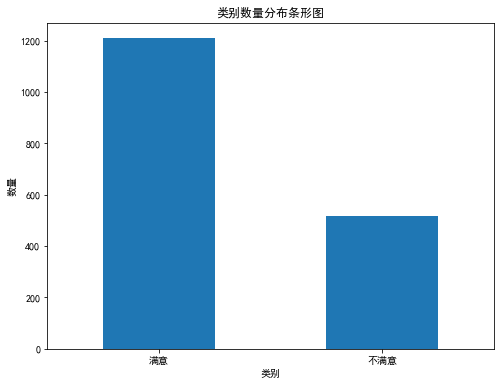

In [22]:
# 使用plt绘制柱形图
plt.figure(figsize=(8,6))
data.car_acceptability.value_counts().plot(kind='bar', rot=360, title='类别数量分布条形图')
plt.xticks([0, 1], ['满意', '不满意'])
plt.xlabel("类别")
plt.ylabel("数量")

[Text(0, 0.5, 'Count'), Text(0.5, 0, 'Class'), Text(0.5, 1.0, '类别数量分布条形图')]

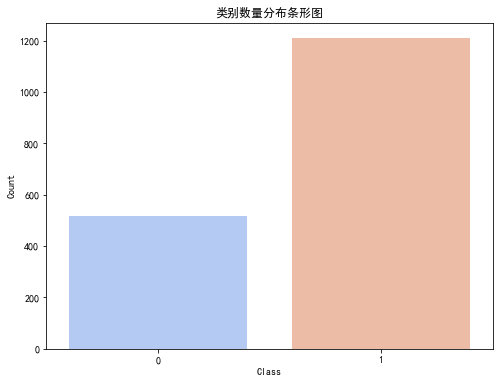

In [23]:
# 还可以使用sns绘制柱形图
plt.figure(figsize=(8,6))
counts = sns.countplot(x='car_acceptability',data=data, palette='coolwarm')
counts.set(xlabel="Class",ylabel="Count",title='类别数量分布条形图')

↑♎：样本不均衡，所以在后续数据集划分的时候，要考虑划分策略，即参数`stratify`。

## 数据集划分
> + 先分离出特征`X`和目标`y`
> + 再将数据集划分为训练集（80%）和测试集（20%）两部分

In [64]:
# 先分离出特征X和目标y
X_total = data.drop(['car_acceptability'],axis=1)
y_total = data['car_acceptability']

In [65]:
# 划分train与test,参数test_size=0.2,random_state=77
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test= train_test_split(X_total,y_total,
                                               test_size=0.2,
                                               random_state=77,
                                               stratify=y_total
                                               )

In [26]:
train_test_split??

**注意：数据分割策略`stratity`**
**如果不是None，则以分层方式拆分数据，使用此作为类标签。**


# 2. 逻辑回归

In [27]:
# 导入所需库,LogisticRegression,confusion_matrix,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## 模型构建与训练

In [56]:
# 模型构建与拟合
##S1: 模型构建，random_state=77
clf = LogisticRegression(random_state=77)
##S2: 模型训练(拟合)
clf.fit(X_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=77, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

## 模型预测

In [57]:
##S3: 模型预测
y_pred_clf =clf.predict(X_test)

In [58]:
y_pred_clf

array([1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,

## 模型评价

### 正确率

In [66]:
# 测试集的分类正确率
clf.score(X_test,y_test)

0.8670520231213873

In [67]:
print("分类正确率ACC:",round(clf.score(X_test,y_test),4))

分类正确率ACC: 0.8671


### 报告

In [33]:
# 构建显示主要分类指标的文本报告
print(classification_report(y_test, y_pred_clf))

              precision    recall  f1-score   support

           0       0.82      0.71      0.76       104
           1       0.88      0.93      0.91       242

    accuracy                           0.87       346
   macro avg       0.85      0.82      0.84       346
weighted avg       0.86      0.87      0.86       346



↑♎：`0`类分类效果较`1`类并不理想

### 混淆矩阵

Text(0.5, 1, '混淆矩阵热力图')

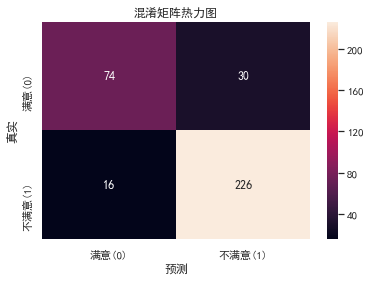

In [34]:
## 设置正常显示中文
sns.set(font='SimHei')
## 绘制热力图
ax = sns.heatmap(confusion_matrix(y_test,y_pred_clf), 
                 annot=True, fmt='d', 
                 xticklabels=["满意(0)","不满意(1)"],
                 yticklabels=["满意(0)","不满意(1)"]
                )
ax.set_ylabel('真实')
ax.set_xlabel('预测')
ax.set_title('混淆矩阵热力图')

↑♎：大约三分之一的“满意”客户被分类错误，被错误的分为"不满意"

## 模型优化
> `LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=77, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)`
          
> LogisticRegression的优化途径：
>> (1) 平衡类别权重：`class_weight ='balanced'|'None'` 默认“None”(权重相等)<br>
(2) 正则化项：`penalty='l2'|'l1'`,默认`l2` <br>
(3) 正则化强度：`C`,正的浮点数，值越小强度越大，默认为1.0 <br>
(4) 选择优化算法:
>>>“liblinear”:坐标轴下降法(默认)<br>
“lbfgs”:拟牛顿法的一种<br>
“newton-cg”:牛顿法的一种<br>
“sag”:随机平均梯度下降<br>

>> 注意：`penalty`设置为`'11'` 时优化算法仅可为`'liblinear'`，原因如下：
>>> `'newton-cg','flbfgs','sag'`这三种优化算法都需要损失函数的一阶或者二阶连续导数,而`11`正则化的损失函数不是连续可导的，但`“liblinear'`没有这个依赖。


In [40]:
## 模型构建与拟合,平衡类别权重,设置class_weight ='balanced'
clf_bala = LogisticRegression(random_state=77, class_weight='balanced')
clf_bala.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=77, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [41]:
# 模型预测
y_pred_bala = clf_bala.predict(X_test)

# 分类正确率
print("分类正确率：",round(clf_bala.score(X_test,y_test),4))
print("--------------------------------------------------------")
# 构建显示主要分类指标的文本报告
print(classification_report(y_test, y_pred_bala))

分类正确率： 0.8728
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.77      0.83      0.80       104
           1       0.92      0.89      0.91       242

    accuracy                           0.87       346
   macro avg       0.85      0.86      0.85       346
weighted avg       0.88      0.87      0.87       346



↑♎从结果看出：`0`类的召回率较之前有所提升，其它指标有所下降，ACC也提高了一点儿

Text(0.5, 1, '混淆矩阵热力图')

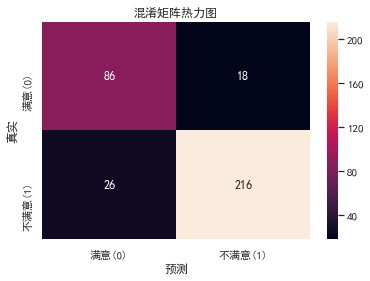

In [38]:
## 绘制热力图
ax = sns.heatmap(confusion_matrix(y_test, y_pred_bala), 
                 annot=True, fmt='d', 
                 xticklabels=["满意(0)","不满意(1)"], 
                 yticklabels=["满意(0)","不满意(1)"]
                )
ax.set_ylabel('真实')
ax.set_xlabel('预测')
ax.set_title('混淆矩阵热力图')

↑♎比较未优化前：
> + 更多的满意客户被分类正确，但作为代价，不满意客户的分类正确率降低。
> + “满意”客户被错误地分为"不满意"的情况有所缓解，但是“不满意”客户被错误地分为"满意"的情况有加重。

## 模型参数
> 调用属性`coef_`和`intercept_`可以查看模型系数和截距项


In [39]:
# 查看intercept_
clf_bala.intercept_

array([6.65371377])

In [68]:
# 查看coef_
clf_bala.coef_

array([[ 0.82254592,  0.80983257, -0.1468501 , -1.94523426, -0.52232275,
        -2.22941536]])

In [69]:
# 构建模型系数Series
index = X_total.columns
coef_s = pd.Series(clf_bala.coef_.reshape(-1), index=index)
coef_s

buying      0.822546
maint       0.809833
doors      -0.146850
persons    -1.945234
lug_boot   -0.522323
safety     -2.229415
dtype: float64

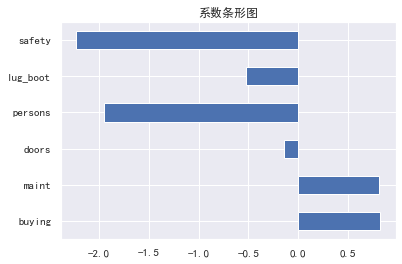

In [70]:
## 绘制横向柱形图查看模型系数
coef_s.plot(kind='barh', title='系数条形图')

↑♎由图知: 安全等级和载客数对模型的预测影响较大，安全等级越低，客户越不满意，载客数越少，客户越不满意。

<div id="3"></div>

# 3. K近邻

**数据准备：**

In [ ]:
# 重新读取文件数据
file_path= "./dataSets/data_chap4/car_evaluate.csv"
data = pd.read_csv(file_path)
# 查看所有特征名称
________

In [ ]:
# 重新分离特征X与目标y，并分割train与test(8:2)，注意stratify
from ________________ import train_test_split

X = data.________________
y = data['car_acceptability']

X_train,X_test,y_train,y_test=train_test_split(X,y,
                                               test_size=0.2,
                                               random_state=77,
                                               ________________
                                              )         

## 模型构建与训练

In [ ]:
# SO：导入KNeighborsClassifier
from ________ import KNeighborsClassifier
# S1：模型构建
kn = ________
# S2：模型拟合
kn.________

**KNeighborsClassifier():**
> + `KNeighborsClassifier(algorithm='auto', leaf_size=30,
metric='minkowski',metric_params=None, n_jobs=None, 
n_neighbors=5, p=2,weights='uniform')`

**模型重要参数解析：**<br>
> (1) `metric='minkowski'`, p=2,距离度量方式为欧式距离 <br>
(2) `n_neighbors=5`,近邻样本的个数选择为5<br>
(3) `weights='uniform'`,不按距离进行加权<br>

## 模型预测与评价

In [ ]:
#S3: 模型预测
y_pred_kn = ________

#S4: 模型评价
## 分类正确率
print("分类正确率ACC：",round(________,4))

## 分类报告
print(________)

## 绘制热力图
ax = sns.heatmap(________________________, 
                 annot=True, fmt='d', 
                 xticklabels=["满意(0)","不满意(1)"], 
                 yticklabels=["满意(0)","不满意(1)"])
ax.set_ylabel('真实')
ax.set_xlabel('预测')
ax.set_title('混淆矩阵热力图')

↑♎结果分析:<br>
> + (1)从ACC看： 分类正确率：0.9769 <br>
> + (2)从report看：二分类评价指标数值较高 <br>
> + (3)从热力图看：绝大部分测试样本都被分类正确 <br>


## 模型优化
> + `KNeighborsClassifier(algorithm='auto', leaf_size=30,
metric='minkowski',metric_params=None, n_jobs=None, 
n_neighbors=5, p=2,weights='uniform')`
                    
>+  KNeighborsClassifier的优化途径：
>> (1) 改变K的取值:`n_neighbors'` 默认5 <br>
(2) 设置K近邻样本的权重：`weights='uniform' | 'distance'`,默认`'uniform'`(权重相等) <br>
(3) 选择距离度量方式：`metric='minkowski',` `p=2` <br>
>>> + 当`𝑝=1`时，闵可夫斯基距离即曼哈顿距离<br>
>>> + 当`𝑝=2`时，闵可夫斯基距离即欧式距离 <br>
>>> + 当`𝑝→∞` 时，闵可夫斯基距离即切比雪夫距离<br>

### K值考察
> 不同K值对分类正确率的影响

In [ ]:
# 不同K值对分类正确率的影响,k in range(1,10)
K_scores = [KNeighborsClassifier(n_neighbors=k)
            .________
            .________
            for________]
K_scores

In [ ]:
plt.plot?

In [ ]:
# 绘制折线图
plt.plot(________,________,'r-.',linewidth=5)
plt.xlabel('K')
plt.ylabel('正确率ACC')
plt.title('不同K值下模型预测正确率')

↑♎分析： 当K=7时，分类正确率最高，大约为0.98，实际应用中，我们取K=5即可。

### 加权K近邻
> + 在上面的基础上，设置`weights='distance'`,考察距离加权下不同K值对分类正确率的影响<br>
> + `weights='distance'`:按距离的倒数分配权重


In [ ]:
# 不同K值对分类正确率的影响,k in range(1,10)
K_scores_weights = [________________________]
K_scores_weights

In [ ]:
# 绘制折线图




↑♎分析： 当K=9时，分类正确率最高，大约为0.99,整体效果强于K近邻。<br>
通过上面的分析可知，K近邻在该任务的表现非常不错。

<div id="4"></div>

# 4. 决策树

**数据准备：**

In [ ]:
file_path= "./dataSets/data_chap4/car_evaluate.csv"
data = pd.read_csv(file_path)
data.columns

In [ ]:
from sklearn.model_selection import train_test_split
X = data.drop(['car_acceptability'],axis=1)
y = data['car_acceptability']
X_train,X_test,y_train,y_test=train_test_split(X,y,
                                               test_size=0.2,
                                               random_state=77,
                                               stratify=y)         

## 模型构建与训练

In [ ]:
# S0:导入DecisionTreeClassifier
from ________ import DecisionTreeClassifier
# S1:模型构建，random_state=10
DF_model = ________
# S2:模型拟合
DF_model.________

**DecisionTreeClassifier():**
> `DecisionTreeClassifier(class_weight=None, criterion='gini', 
            max_depth=None,max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, 
            random_state=10, splitter='best')`

**模型重要参数分析：**<br>
> + (1) `class_weight=None`:各类别权重一致<br>
> + (2) `criterion='gini'`:CART分类树<br>
> + (3) `max_depth=None`:不限制树的生长<br>

## 模型预测与评价


In [ ]:
# 模型预测
y_pred_DF = DF_model.________

# 分类正确率
print("分类正确率ACC：",round(________________,4))

# 分类报告
print(classification_report(________, ________))

# 绘制热力图
ax = sns.heatmap(________________________, 
                 annot=True, fmt='d', 
                 xticklabels=["满意(0)","不满意(1)"],
                 yticklabels=["满意(0)","不满意(1)"])
ax.set_ylabel('真实')
ax.set_xlabel('预测')
ax.set_title('混淆矩阵热力图')

↑♎结果分析：<br>
> + (1)从分类正确率ACC看：分类正确率：0.983<br>
> + (2)从分类报告看：二分类评价指标目前最高<br>
> + (3)从混淆矩阵图看：测试样本中分类效果目前最好<br>

## 特征重要性
> 训练模型后，调用属性`feature_importances_`可以查看各特征的重要性


In [ ]:
# 查看模型重要系数 
DF_model.________________

In [ ]:
# 提取各特征名称，准备构建Series
index = X_train.columns

In [ ]:
# 构造特征重要性序列，降序，绘制'barh'图
pd.Series(________________,index=________________).________.plot(________,title='特征重要性')

↑♎分析：安全等级和载客人数排在重要性的前两位，与逻辑回归一致

## 模型优化
> ▶`DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best')`
            
            
>DecisionTreeClassifier的优化途径：<br>
>> (1) 设置树生长的最大深度:`max_depth'` 默认`None`(不限制) <br>
(2) 结点不纯度的度量方法:`criterion`默认为`"gini"`（CART），可设置为`"entropy"` <br>
(3) 设置各个类别的权重：`class_weight`,默认为`None`（权重一致） <br>

>更多参数详情请参考官方文档：<br>
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier


### 限制树的最大深度
> 考察不同树深度`max_depth`下模型的分类正确率


In [ ]:
# 限制树深度对分类正确率的影响
depth_grid = [1, 3, 5, 7, 9, None]
depth_scores = [________________________
                .________________
                .________________
                for item in depth_grid]
depth_scores

In [ ]:
# 绘制折线图
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(depth_scores, 'b-*', linewidth=1)
plt.xticks(range(6), [1, 3, 5, 7, 9, 'None'])
plt.xlabel('深度')
plt.ylabel('正确率')
plt.title('不同树深度下模型分类正确率')

↑♎分析：模型分类ACC随树深度的增加而提高，所以不需要对树作生长深度上的限制

## 决策树可视化
> 树深度限制为3，训练后可视化决策树模型


In [ ]:
# 构建模型，max_depth=3
DF_model_3 = DecisionTreeClassifier(random_state=10, max_depth=3)
# 训练模型
DF_model_3.fit(X_train, y_train)

In [ ]:
# 决策树可视化
## 导入必要库
from sklearn.tree import export_graphviz
#from sklearn.externals.six import StringIO   # 0.22版本之前用
from six import StringIO
from IPython.display import Image 
import pydotplus

In [ ]:
## 输出图片到dot文件
export_graphviz(DF_model_3, out_file='tree.dot', 
                feature_names=X_train.columns,
                rounded=True, filled=True,
                class_names=['acc', 'unacc'])

## 使用dot文件构造图
graph= pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

**↑♎分析：** <br>
> ●每个结点中显示下列信息：
>> ▶(1)特征划分条件<br>▶(2)基尼系数的值<br>▶(2)总样本量<br>▶(4)每个类别的样本量<br>

> + 当安全系数小于等于1.5人时，预测类别为“不满意”<br>
> + 当安全系数大于1.5且载客数大小于1.5人时，预测类别为“不满意”<br>
> + 当载客数和安全等级大于1.5人时，购买价格小于等于2.5预测类别为“满意”，否则为“不满意”<br>

<div id="5"></div>

# 5. 朴素贝叶斯

> naive_bayes模块
>
|类	|名称	|说明|
|------:|------:|------:|
|GaussianNB()	|高斯朴素贝叶斯	|主要面对输入为连续型的情况，通过假设高斯分布计算类条件概率|
|BernoulliNB()	|伯努利朴素贝叶斯	|主要面对输入为离散型的情况，将特征二值化，例如一个词在文本中是否出现（1为是，0为否）|
|MultinomialNB()|	多项式朴素贝叶斯|	主要面对输入为离散型的情况，例如一个词在不同文档中出现的次数|


In [ ]:
# 重新准备数据
file_path= "./dataSets/data_chap4/car_evaluate.csv"
data = pd.read_csv(file_path)
# 查看所有列名
data.columns

In [ ]:
# 分离X与y; 分割train与test(8:2)
from sklearn.model_selection import train_test_split
X = data.drop(['car_acceptability'],axis=1)
y = data['car_acceptability']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,
                                               random_state=77)         

In [ ]:
# 模型评价所需相关库:accuracy_score,confusion_matrix,classification_report
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

## 5.1 Gaussian朴素贝叶斯

### GaussianNB建模及评估

In [ ]:
## 载入算法类
from ________ import GaussianNB

# 模型构建与拟合
GNB = ________
GNB.________

**重要参数：**<br>
> `priors`:	自行设定类别先验概率，默认为None（学习先验概率）

In [ ]:
# 模型预测
y_pred_GNB = ________

# 分类正确率
print("分类正确率：",round(________,4))

# 分类报告
print(________________)

# 绘制热力图
ax = sns.heatmap(________, 
                 annot=True, fmt='d', 
                 xticklabels=["满意(0)","不满意(1)"], 
                 yticklabels=["满意(0)","不满意(1)"])
ax.set_ylabel('真实')
ax.set_xlabel('预测')
ax.set_title('混淆矩阵热力图')

**↑♎分析：** <br>
> + (1) 分类正确率：0.88 <br>
> + (2) 分类报告看：0的效果差，召回仅为0.7；<br>
> + (3) 混淆矩阵热力图看：效果不理想！<br> 

> + 为什么不好呢？
>> + 使用`GaussianNB`建模是假设特征符合高斯分布，效果差，说明实际不符合。
 
> + 另外两种算法怎么样呢？后续将进行考察<br>


### GaussianNB模型参数及可视化
>模型主要参数：<br>
>> (1) 先验概率:<br>
(2) 模型均值:<br>
(3) 模型方差:<br>

In [ ]:
## 查看先验概率和特征的均值方差
### 先验概率
print(GNB.class_prior_)

**↑♎分析：** 
> + 查看1.4节中`0`和`1`的样本数；`0:518`;`1:1210`；
> + 先验概率体现了各类别样本的数量比。

In [ ]:
### 均值
print(GNB.theta_)

### 方差
print(GNB.sigma_)

**↑♎分析：** 均值与方差体现各个特征的高斯分布情况。

In [ ]:
## 不同类别下特征均值条形图
pd.DataFrame(________, columns=['0类(满意)', '1类(不满意)']).plot(kind='bar',rot=360, title='不同类别下特征均值条形图')
plt.ylim(0, 3.5)
plt.xticks(________, ________)

**↑♎分析：** 均值可以体现特征重要性，`safety`,`persons`,`doors`特征较重要,跟之前逻辑回归得到的结果接近。

In [ ]:
## 不同类别下特征方差条形图

#plt.ylim(0, 2)
plt.xticks(range(6), X_train.columns)

**↑♎分析：** 方差体现特征中样本分散性，各个特征在`1类(不满意)`中的分散性均较大,都大于`0类(满意)`类。

### 特征Gaussian曲线
> 这个部分有能力的同学自学。
> 正态分布函数：
$$
f(x) = 
$$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

# 定义正态分布函数 
def normal_distribution(x, mean, sigma):
    '''
    x
    mean:均值
    sigma:方差
    '''
    return np.exp(-1*((x-mean)**2)/(2*(sigma**2)))/(math.sqrt(2*np.pi) * sigma)

In [ ]:
# 设置均值为0，方差为1
mean1, sigma1 = 0, 1
# 构造x1，100个点均匀分布于[-6,+6]间
x1 = np.linspace(mean1 - 6*sigma1, mean1 + 6*sigma1, 100)
 
mean2, sigma2 = 0, 2
x2 = np.linspace(mean2 - 6*sigma2, mean2 + 6*sigma2, 100)
 
mean3, sigma3 = 5, 1
x3 = np.linspace(mean3 - 6*sigma3, mean3 + 6*sigma3, 100)
 
y1 = normal_distribution(x1, mean1, sigma1)
y2 = normal_distribution(x2, mean2, sigma2)
y3 = normal_distribution(x3, mean3, sigma3)
 
plt.plot(x1, y1, 'r', label='m=0,sig=1')
plt.plot(x2, y2, 'g', label='m=0,sig=2')
plt.plot(x3, y3, 'b', label='m=1,sig=1')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# 0类和1类的6个特征的均值
mean_s0 = [2.13397129,2.19617225,2.60526316,2.49282297,2.18660287,2.58133971]
mean_s1 = [2.59854772,2.62966805,2.45435685,1.78838174,1.92116183,1.74585062]

# 0类和1类的6个特征的方差
sigma_s0 = [1.03946796,1.04764085,1.19107278,0.24994849,0.6063277,0.24338385]
sigma_s1 = [1.27140868,1.26015715,1.25829015,0.70625506,0.67428247,0.64598901]


# 0类第一个特征'buying'的高斯曲线
mean1, sigma1 = mean_s0[0], sigma_s0[0]    
x1 = np.linspace(mean1 - 6*sigma1, mean1 + 6*sigma1, 100)

# 1类第一个特征'buying'的高斯曲线
mean2, sigma2 = mean_s1[0], sigma_s1[0]
x2 = np.linspace(mean2 - 6*sigma2, mean2 + 6*sigma2, 100)

# 0类第三个特征'doors'的高斯曲线 
mean3, sigma3 = mean_s0[2], sigma_s0[2]
x3 = np.linspace(mean3 - 6*sigma3, mean3 + 6*sigma3, 100)

# 0类第三个特征'doors'的高斯曲线 
mean4, sigma4 = mean_s1[2], sigma_s1[2]
x4 = np.linspace(mean4 - 6*sigma4, mean3 + 6*sigma4, 100)
 
y1 = normal_distribution(x1, mean1, sigma1)
y2 = normal_distribution(x2, mean2, sigma2)
y3 = normal_distribution(x3, mean3, sigma3)
y4 = normal_distribution(x4, mean4, sigma4)
 
plt.plot(x1, y1, 'r', label='m=0,sig=1')
plt.plot(x2, y2, 'g', label='m=0,sig=2')
plt.plot(x3, y3, 'b', label='m=1,sig=1')
plt.plot(x4, y4, 'purple', label='m=1,sig=1')
plt.legend()
plt.grid(True)
plt.show()

## 5.2 多项式朴素贝叶斯


### MultinomialNB建模与评价

In [ ]:
from ________________ import MultinomialNB

# 模型构建与拟合
MNB = ________
MNB.________

**MultinomialNB():**
> + MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

> + **重要参数：**<br>

|参数|	说明|
|----:|-----:|
|alpha|	添加拉普拉斯平滑系数，默认为1.0|
|fit_prior	|是否学习先验概率，默认为True，若为False，则所有类别先验概率一致|
|class_prior|	自行设定类别先验概率，默认为None（学习先验概率）|

In [ ]:
# 模型预测
y_pred_MNB = MNB.________

# 分类正确率
print("分类正确率ACC：",round(________,4))

# 分类报告
print(classification_report(________, ________))

# 绘制热力图
ax = sns.heatmap(________________________, 
                 annot=True, fmt='d', 
                 xticklabels=["满意(0)","不满意(1)"], 
                 yticklabels=["满意(0)","不满意(1)"])
ax.set_ylabel('真实')
ax.set_xlabel('预测')
ax.set_title('混淆矩阵热力图')

**↑♎分析：**  发现结果更差了，分类正确率ACC只有0.7，其原因：
> + `MultinomialNB`主要用于输入为离散型的情况，即**特征值之间相互独立**，而该项目的特征不能被看成离散型，
> + 例如`doors`的取值，2,3,4,5,more，这些数值之间不是完全没有联系的，有大小关系存在。
> + 所以，效果差的原因就是该项目选用该模型不合适。

### MultinomialNB模型属性
> 训练模型后，`MultinomialNB`和`BernoulliNB`类可以查看下列属性：
>> |属性|	说明|
|---:|---:|
|class_log_prior_  |	每个类别的对数平滑先验概率|
|feature_log_prob_	|不同类别下各特征的对数类条件概率|
|class_count_	|不同类别下样本的个数|
|feature_count_	|不同类别下特征取值的加和|

In [ ]:
MNB.class_log_prior_

In [ ]:
MNB.feature_log_prob_

In [ ]:
MNB.class_count_

In [ ]:
MNB.feature_count_

## 5.3 Bernoulli朴素贝叶斯

### BernoulliNB建模与评价

In [ ]:
# 导入库BernoulliNB
from sklearn.naive_bayes import BernoulliNB

# 模型构建与拟合
BNB = BernoulliNB(binarize=2.0)
BNB.fit(X_train, y_train)

**BernoulliNB():**
> + `BernoulliNB(alpha=1.0, binarize=2.0, class_prior=None, fit_prior=True)`

**重要参数：** <br>

|参数|	说明|
|----:|-----:|
|alpha|	添加拉普拉斯平滑系数，默认为1.0|
|binarize（BernoulliNB）|	二值化的阈值，默认为0.0|
|fit_prior	|是否学习先验概率，默认为True，若为False，则所有类别先验概率一致|
|class_prior|	自行设定类别先验概率，默认为None（学习先验概率）|

In [ ]:
# 模型预测
y_pred_BNB = BNB.predict(X_test)

# 分类正确率
print("分类正确率：",round(BNB.score(X_test, y_test),4))

# 分类报告
print(classification_report(y_test, y_pred_BNB))

# 绘制热力图
ax = sns.heatmap(confusion_matrix(y_test, y_pred_BNB), 
                 annot=True, fmt='d', 
                 xticklabels=["满意(0)","不满意(1)"], yticklabels=["满意(0)","不满意(1)"])
ax.set_ylabel('真实')
ax.set_xlabel('预测')
ax.set_title('混淆矩阵热力图')

**↑♎分析：** 其效果跟`MultinomialNB`差不多，其主要原因也类似：
> + `BernoulliNB`主要面对输入为离散型的情况，将特征二值化，例如一个词在文本中是否出现（1为是，0为否）,该项目使用该模型不适合。


### BernoulliNB模型属性
> 训练模型后，MultinomialNB和BernoulliNB类可以查看下列属性：
>> |属性|	说明|
|---:|---:|
|class_log_prior_  |	每个类别的对数平滑先验概率|
|feature_log_prob_	|不同类别下各特征的对数类条件概率|
|class_count_	|不同类别下样本的个数|
|feature_count_	|不同类别下特征取值的加和|

In [ ]:
BNB.class_log_prior_

In [ ]:
BNB.feature_log_prob_

In [ ]:
BNB.class_count_

In [ ]:
BNB.feature_count_

<div id="6"></div>

# 6. 支持向量机

**数据准备：**

In [ ]:
# 读取文件数据
file_path= "./dataSets/data_chap4/car_evaluate.csv"
data = pd.read_csv(file_path)
data.columns

In [ ]:
# X,y分离，train与test分割（8:2）
from sklearn.model_selection import train_test_split
X = data.drop(['car_acceptability'],axis=1)
y = data['car_acceptability']
X_train,X_test,y_train,y_test=train_test_split(X,y,
                                               test_size=0.2,
                                               random_state=77)         

In [ ]:
# 模型评价所需相关库：accuracy_score,confusion_matrix,classification_report
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

## 6.1 LinearSVC

### LinearSVC模型创建与评价

In [ ]:
# 载入库LinearSVC
from _______________ import LinearSVC

# 模型构建与拟合
##  # max_iter=10000,可去除警告ConvergenceWarning: Liblinear failed to converge
lsvm = LinearSVC(random_state=10,max_iter=10000)  
lsvm.________

LinearSVC:
> `LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=10000,
     multi_class='ovr', penalty='l2', random_state=10, tol=0.0001,
     verbose=0)`

主要参数说明：

>|参数|	说明|
|----:|-----:|
|penalty	|指定优化时使用的范数类型，默认为”l2”，可设置为”l1”|
|loss	|指定优化时的损失函数，默认为”squared_hinge”（平方合页损失）|
|C	|设置惩罚系数，默认为1.0|
|multi_class	|处理多分类问题的策略，默认为”ovr”（一对多）|
|class_weight	|设置不同类别的分类权重|


In [ ]:
# 模型预测
y_pred_lsvm = ________

# 分类正确率
print("分类正确率ACC：",round(________,4))

# 分类报告
print(________)

# 绘制热力图
ax = sns.heatmap(________, 
                 annot=True, fmt='d', 
                 xticklabels=["满意(0)","不满意(1)"],
                 yticklabels=["满意(0)","不满意(1)"])
ax.set_ylabel('真实')
ax.set_xlabel('预测')
ax.set_title('混淆矩阵热力图')

**↑♎分析：**
> + (1)从分类正确率ACC看：0.85，还可以 <br>
> + (2)从分类报告看：1类的效果明显好于0类
> + (3)从混淆矩阵热力图：0类有近三分之一分错了。

> + 尝试调整参数的值，观察是否可以进一步提高模型效果


### LinearSVC模型优化
> + 原模型：<br>
`LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=10, tol=0.0001,
     verbose=0)`
     
> + 常用优化途径：<br>
>> + (1)调整惩罚系数`C`：[0.01, 0.1, 0.5, 1, 2, 5, 10]<br>
>> + (2) 改变正则项`penalty`:‘l2’或‘l1’

> + 接下来，考察**不同惩罚系数`C`下模型分类正确率**


In [ ]:
# 构造惩罚系数C的列表C_grid 
C_grid = [0.1, 0.3, 0.5, 0.7, 1, 2, 5, 10, 100]
# 不同C下的模型构建 -> 训练 ->评价
C_scores = [LinearSVC(C=c, random_state=10,max_iter=10000)   # max_iter=10000,可去除警告ConvergenceWarning: Liblinear failed to converge,
            .______________
            .______________
            for c in C_grid ]

# 绘制折线图
plt.figure(figsize=(8, 6))
plt.plot(______________, 'm-x', linewidth=2)
plt.xticks(range(9), C_grid)
plt.xlabel('惩罚系数')
plt.ylabel('正确率')
plt.title('不同惩罚系数下模型分类正确率')

**↑♎分析：**
> + C=2或5或10时，模型可以取得最佳的正确率；随着C的增大，C越大，对错误的容忍程度就越小，分类正确率会降低.

### LinearSVC模型参数
> 调用属性`coef_`和`intercept_`可以查看模型系数和截距项


In [ ]:
# 查看截距项
lsvm.intercept_

In [ ]:
# 查看模型系数
lsvm.coef_

In [ ]:
# 以上系数对应的特征名称
index = X_train.columns
index

In [ ]:
# 绘图
pd.Series(______________,index=X_train.columns).plot(kind='barh', title='系数条形图',grid=True)

**↑♎分析：** 将2.5节中逻辑回归的系数图与该线性支持向量机的系数条形图进行对比，不难发现，基本一致。

## SVC
> 构建非线性支持向量机模型


### SVC模型构建与评价

In [ ]:
# 载入算法类SVC
from ______________ import SVC

# 模型构建与拟合
ksvm = SVC(random_state=10)
ksvm.______________

In [ ]:
# 模型预测
y_pred_ksvm = ksvm.______________

# 分类正确率
print("分类正确率：",round(ksvm.score(X_test, y_test),4))

# 分类报告
print(classification_report(______________, ______________))

# 绘制热力图
ax = sns.heatmap(____________________________, 
                 annot=True, fmt='d', 
                 xticklabels=["满意(0)","不满意(1)"], 
                 yticklabels=["满意(0)","不满意(1)"])
ax.set_ylabel('真实')
ax.set_xlabel('预测')
ax.set_title('混淆矩阵热力图')

**↑♎分析：** 
> + (1)从分类正确率看：ACC=0.96 <br>
> + (2)从分类报告看：O类和1类的效果均比较好<br>
> + (3) 从混淆矩阵热力图看：效果比较好<br>

> + 综合效果较好，等同于决策树，好的原因：该**项目属于非线性分类问题**。

### SVC模型优化
> 原SVC模型：<br>
>> `SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=10,
  shrinking=True, tol=0.001, verbose=False)`
  
> 常用优化途径：
>> (1) 调整核函数：`kernel='rbf',`:`['poly','sigmoid']`<br>
(2) 调整惩罚系数的取值： `C`：`[0.001, 0.1, 0.5, 1, 2, 5, 10] `  <br>
(3) 调整径向基核函数中窗宽参数的取值：`gamma`:`[0.001, 0.1, 0.5, 1, 2, 5, 10]`  <br>

**（1）更换核函数**

In [ ]:
# 调整核函数
kernel_grid = ['poly','sigmoid']
kernel_scores = [SVC(______________, random_state=10,gamma='auto')
                 .______________
                 .______________ 
                for k in kernel_grid]
print(pd.Series(kernel_scores, index=['poly', 'sigmoid']))

**↑♎分析：** 
> + (1) 使用多项式核函数效果好，与'rbf'高斯核函数效果接近<br>
> + (2) 使用sigmoid核函数效果差

**（2）调整惩罚系数**

In [ ]:
# 调整惩罚系数的取值
C_grid = [0.1, 0.3, 0.5, 0.7, 1, 2, 5, 10, 100]
C_scores = [SVC(______________, random_state=10,gamma='auto')
            .______________
            .______________ 
            for c in C_grid]

# 绘制折线图
plt.figure(figsize=(8, 6))
plt.plot(C_scores, 'k-o', linewidth=2)
plt.xticks(range(9), C_grid)
plt.xlabel('惩罚系数')
plt.ylabel('正确率')
plt.title('不同惩罚系数下模型分类正确率')

**↑♎分析：** 模型分类正确率随着C的增大而提高，但实际应用中不宜设置C过大。

**(3) 调整径向基核函数中窗宽参数`gamma`的取值**

In [ ]:
# 调整径向基核函数中窗宽参数的取值
gamma_grid = [0.001, 0.1, 0.5, 1, 2, 5, 10]
gamma_scores = [SVC(______________, random_state=10)
           .______________
           .______________
           for g in gamma_grid]

# 绘制折线图
plt.figure(figsize=(8, 6))
plt.plot(gamma_scores, 'k-o', linewidth=2)
plt.xticks(range(7),gamma_grid)
plt.xlabel('惩罚系数')
plt.ylabel('正确率')
plt.title('不同惩罚系数下模型分类正确率')

 **↑♎分析：** 当`gamma=1`时，SVC的核函数取`kernel=rbf`(高斯核函数)效果最好

### 查看支持向量
> 使用训练后的模型,访问其属性`support_vectors_`可查看模型的支持向量

In [ ]:
# 查看支持向量
# 为了表示方便，只输出了列表前10个
vc = SVC(C=5, random_state=10).fit(X_train,y_train).support_vectors_[:10]
print(vc)

In [ ]:
# 对应的特征名称
index = X_train.columns
index

In [ ]:
print(index)
print(vc)

 **↑♎分析：**支持向量就是分类边界，就是通过以上支持向量，将数据分成了0类和1类的；当数据越过支持向量的边界，类别就会发生变化。

# 小结

> + 本章介绍的分类模型有：<br>
>> ● 逻辑回归：`from sklearn.linear_model import LogisticRegression` <br>
● K-近邻：`from sklearn.neighbors import KNeighborsClassifier` <br>
● 决策树：`from sklearn.tree import DecisionTreeClassifier` <br>
● 朴素贝叶斯-1：`from sklearn.naive_bayes import GaussianNB` <br>
● 朴素贝叶斯-2：`from sklearn.naive_bayes import BernoulliNB`  <br>
● 朴素贝叶斯-3：`from sklearn.naive_bayes import MultinomialNB` <br>
● 支持向量机-1: `from sklearn.svm import LinearSVC`  <br>
● 支持向量机-2: `from sklearn.svm import SVC`  <br>

> + 通过数据集Car Evaluation这一二分类任务，对Sklearn中分类模型进行了详细介绍，从模型构建-->训练-->预测-->优化-->可视化等方面进行了训练，要注重掌握模型的适用场合，以期达到融会贯通、学以致用的目的。



